# **RBF Regression**
## *Gitopoulos Giorgos, 9344*
### *Computational Intelligence, ECE AUTh* - *August 2022*

The goal of this project is the construction, training and evaluation of an *RBF Neural Network* to be used for regression. *Boston housing* dataset, which consists of 506 samples with 13 features, is used and the final model is going to predict the value of houses in Boston with respect to their features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf 
from tensorflow import keras
from keras import Input
from lib import utils
from lib import rbf_layer

# ---------------------------------------------------------------------------- #
#                                   read data                                  #
# ---------------------------------------------------------------------------- #

# data = "http://lib.stat.cmu.edu/datasets/boston"
data = "boston.csv"
raw_df = pd.read_csv(data, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]
print("Inputs:")
utils.data_summary(X)
print("Outputs:")
utils.data_summary(y)

Inputs:
Shape = (506, 13)
Minimum = 0.0
Maximum = 711.0
Range = 711.0
Variance = 21070.130450709916
Standard Deviation = 145.1555388220164

Outputs:
Shape = (506,)
Minimum = 5.0
Maximum = 50.0
Range = 45.0
Variance = 84.41955615616556
Standard Deviation = 9.188011545278203



After loading the dataset and presenting its properties, we are going to normalize it and split it (80% for training, 20% for evalutation).

In [2]:
# ---------------------------------------------------------------------------- #
#                                normalize data                                #
# ---------------------------------------------------------------------------- #

preprocessing.scale(X, copy=False, axis=0)
print("Normalized Inputs:")
utils.data_summary(X)

Normalized Inputs:
Shape = (506, 13)
Minimum = -3.9071933049810412
Maximum = 9.933930601860267
Range = 13.841123906841307
Variance = 1.0
Standard Deviation = 1.0



In [3]:
# ---------------------------------------------------------------------------- #
#                      split data to training and testing                      #
# ---------------------------------------------------------------------------- #

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Training Inputs:")
utils.data_summary(X_train)
print("Testing Inputs:")
utils.data_summary(X_test)

print("Training Outputs:")
utils.data_summary(y_train)
print("Testing Outputs:")
utils.data_summary(y_test)

n_train = X_train.shape[0]

Training Inputs:
Shape = (404, 13)
Minimum = -3.9071933049810412
Maximum = 9.933930601860267
Range = 13.841123906841307
Variance = 0.9948683723560822
Standard Deviation = 0.9974308860046807

Testing Inputs:
Shape = (102, 13)
Minimum = -3.8821945679249596
Maximum = 8.136883506576424
Range = 12.019078074501383
Variance = 1.0203003801045392
Standard Deviation = 1.0100991932006178

Training Outputs:
Shape = (404,)
Minimum = 5.0
Maximum = 50.0
Range = 45.0
Variance = 85.1437202235075
Standard Deviation = 9.227335488834656

Testing Outputs:
Shape = (102,)
Minimum = 5.6
Maximum = 50.0
Range = 44.4
Variance = 81.42843906189927
Standard Deviation = 9.02377077844397



The model is going to consist of an input layer (13x1), a hidden *RBF* layer which applies a *gaussian kernel* to the input data and a dense output layer with 128 neurons and *ReLU* activation function. 

The *RBF* kernel is 
$$f(x) = \frac{e ^ {- \left| \left| x - c_i \right| \right| ^2}}{2 \sigma_i ^2}$$
where $x$ is an input vector and $c_i$, $\sigma_i$ are the center and the variance of the $i$-th neuron respectively. The centers $c_i$ are initialized through *K-Means* algorithm and the variance $\sigma_i$ of each neuron is set 
$$ \sigma = \frac{d_{max}}{\sqrt{2P}}$$
where $d_{max}$ is the maximum distance between two centers and $P$ is the number of neurons of the *RBF* layer. 

For the size of the *RBF* layer, we use the values 10%, 50% and 90% of the size of the training dataset, so we train three different models.
Having the *RBF* parameters pre-computed and fixed, the goal of the training process is to find the optimal $W$ and $b$ vectors of the output layer.

In [4]:
# ---------------------------------------------------------------------------- #
#                          neural network construction                         #
# ---------------------------------------------------------------------------- #

hidden_size_1 = int(0.1 * n_train)
hidden_size_2= int(0.5 * n_train)
hidden_size_3 = int(0.9 * n_train)

model_1 = keras.Sequential(name="model_1")
model_1.add(Input(shape=(13,)))
model_1.add(rbf_layer.RBF(hidden_size_1, utils.InitCentersKMeans(X_train)))
model_1.add(keras.layers.Dense(128, activation="relu"))
model_1.add(keras.layers.Dense(1, activation="relu"))

model_1.summary()

model_2 = keras.Sequential(name="model_2")
model_2.add(Input(shape=(13,)))
model_2.add(rbf_layer.RBF(hidden_size_2, utils.InitCentersKMeans(X_train)))
model_2.add(keras.layers.Dense(128, activation="relu"))
model_2.add(keras.layers.Dense(1, activation="relu"))

model_2.summary()

model_3 = keras.Sequential(name="model_3")
model_3.add(Input(shape=(13,)))
model_3.add(rbf_layer.RBF(hidden_size_3, utils.InitCentersKMeans(X_train)))
model_3.add(keras.layers.Dense(128, activation="relu"))
model_3.add(keras.layers.Dense(1, activation="relu"))

model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf (RBF)                   (None, 40)                520       
                                                                 
 dense (Dense)               (None, 128)               5248      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,897
Trainable params: 5,377
Non-trainable params: 520
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_1 (RBF)                 (None, 202)               2626      
                                                                 
 dense_2 (Dense)             (None, 12

We use *Stochastic Gradient Descent* optimizer with $l_r = 0.001$ and *Mean Squared Error* as loss function to train the model. We also compute *RMSE* and $R^2$ as evaluation metrics.

# **$1$. Model_1 ($hidden\_size = 0.1 \times n\_train$)**

In [ ]:
# ---------------------------------------------------------------------------- #
#                            neural network training                           #
# ---------------------------------------------------------------------------- #

opt = keras.optimizers.SGD(learning_rate=0.001)
model_1.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[utils.root_mean_squared_error, utils.coeff_determination])
history = model_1.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

4/4 [==============================] - 0s 993us/step - loss: 80.4301 - root_mean_squared_error: 8.2840 - coeff_determination: -0.0567


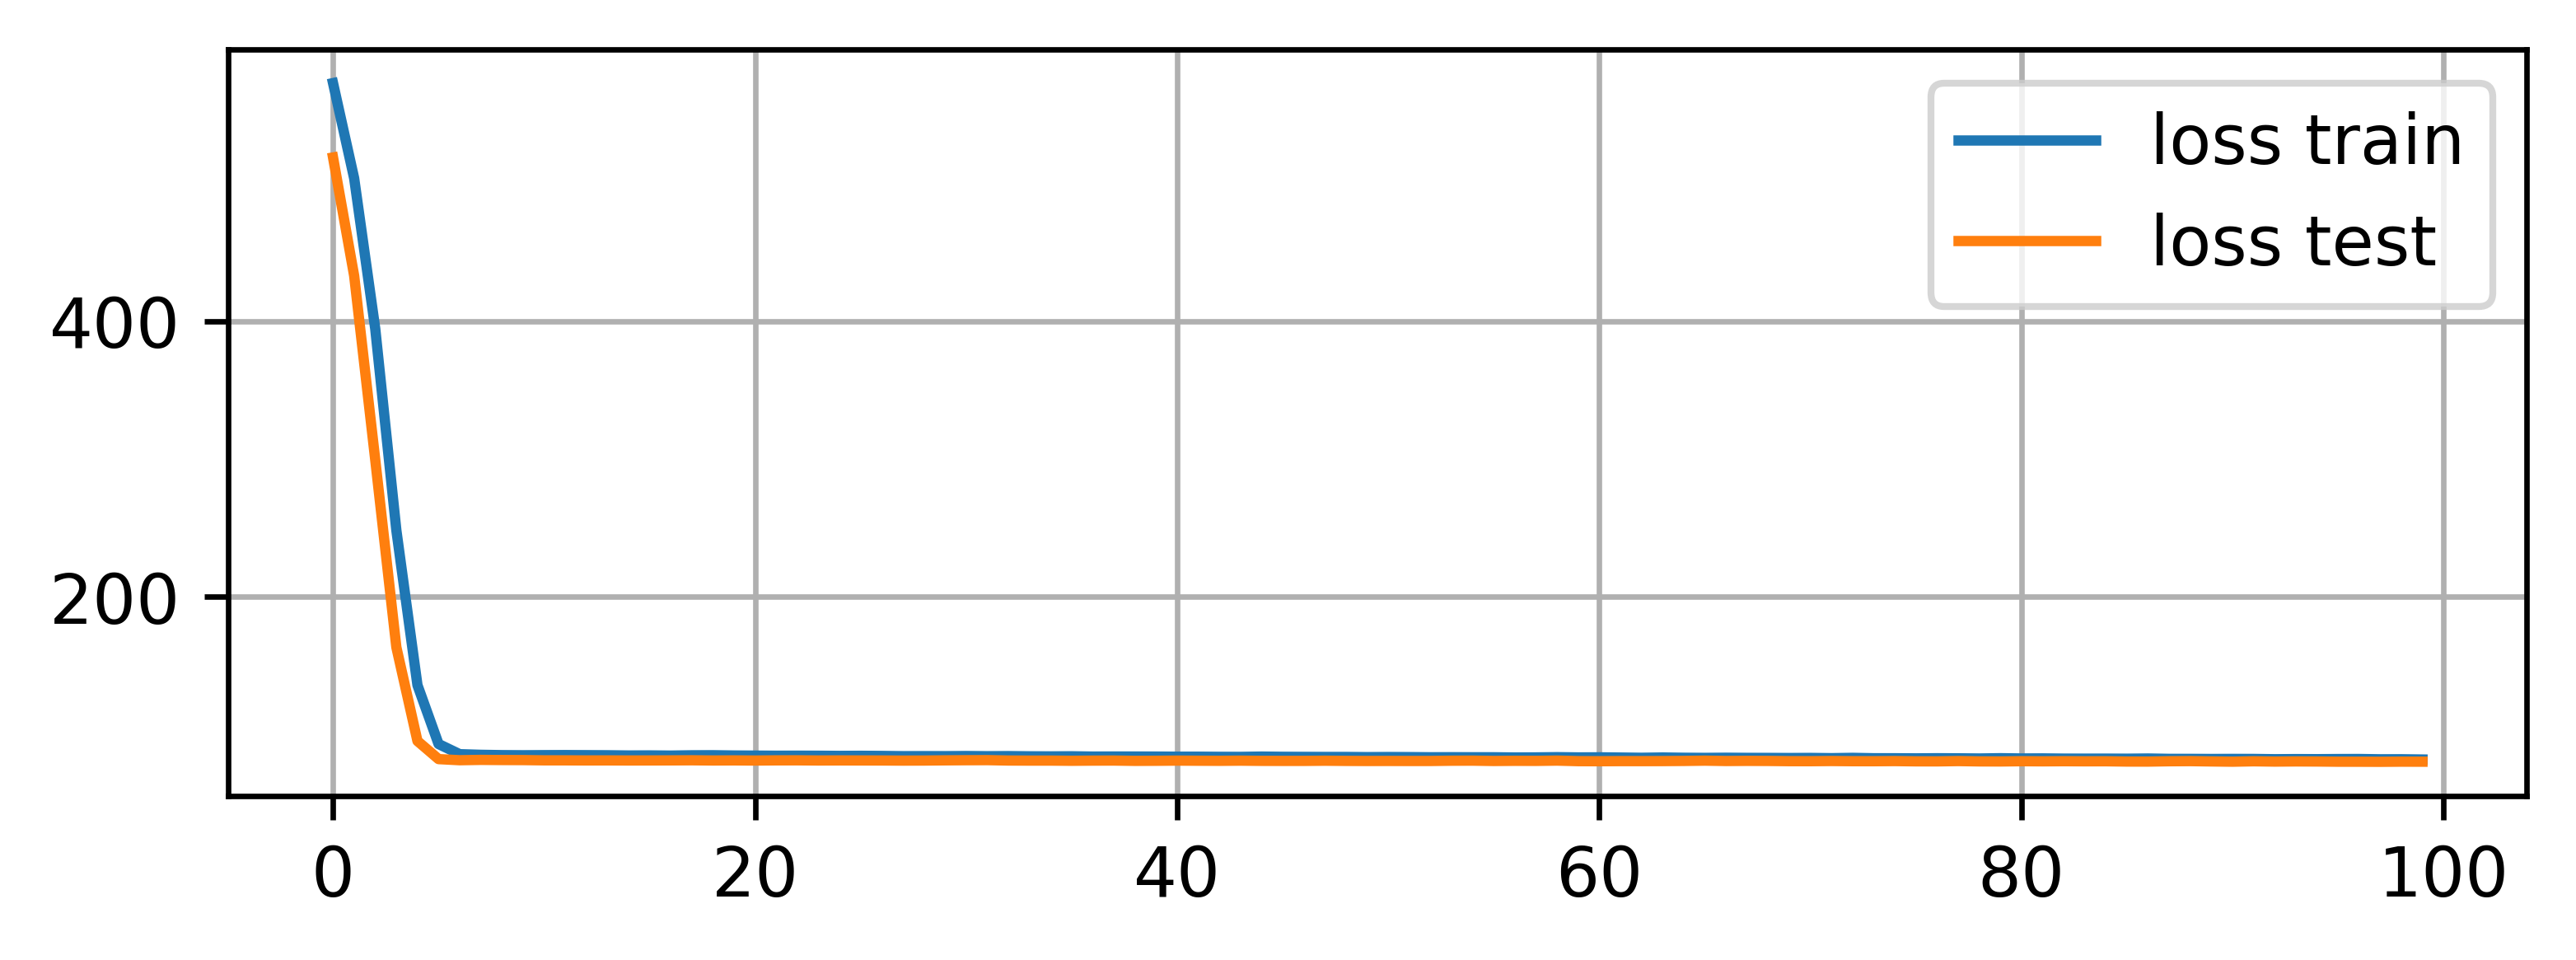

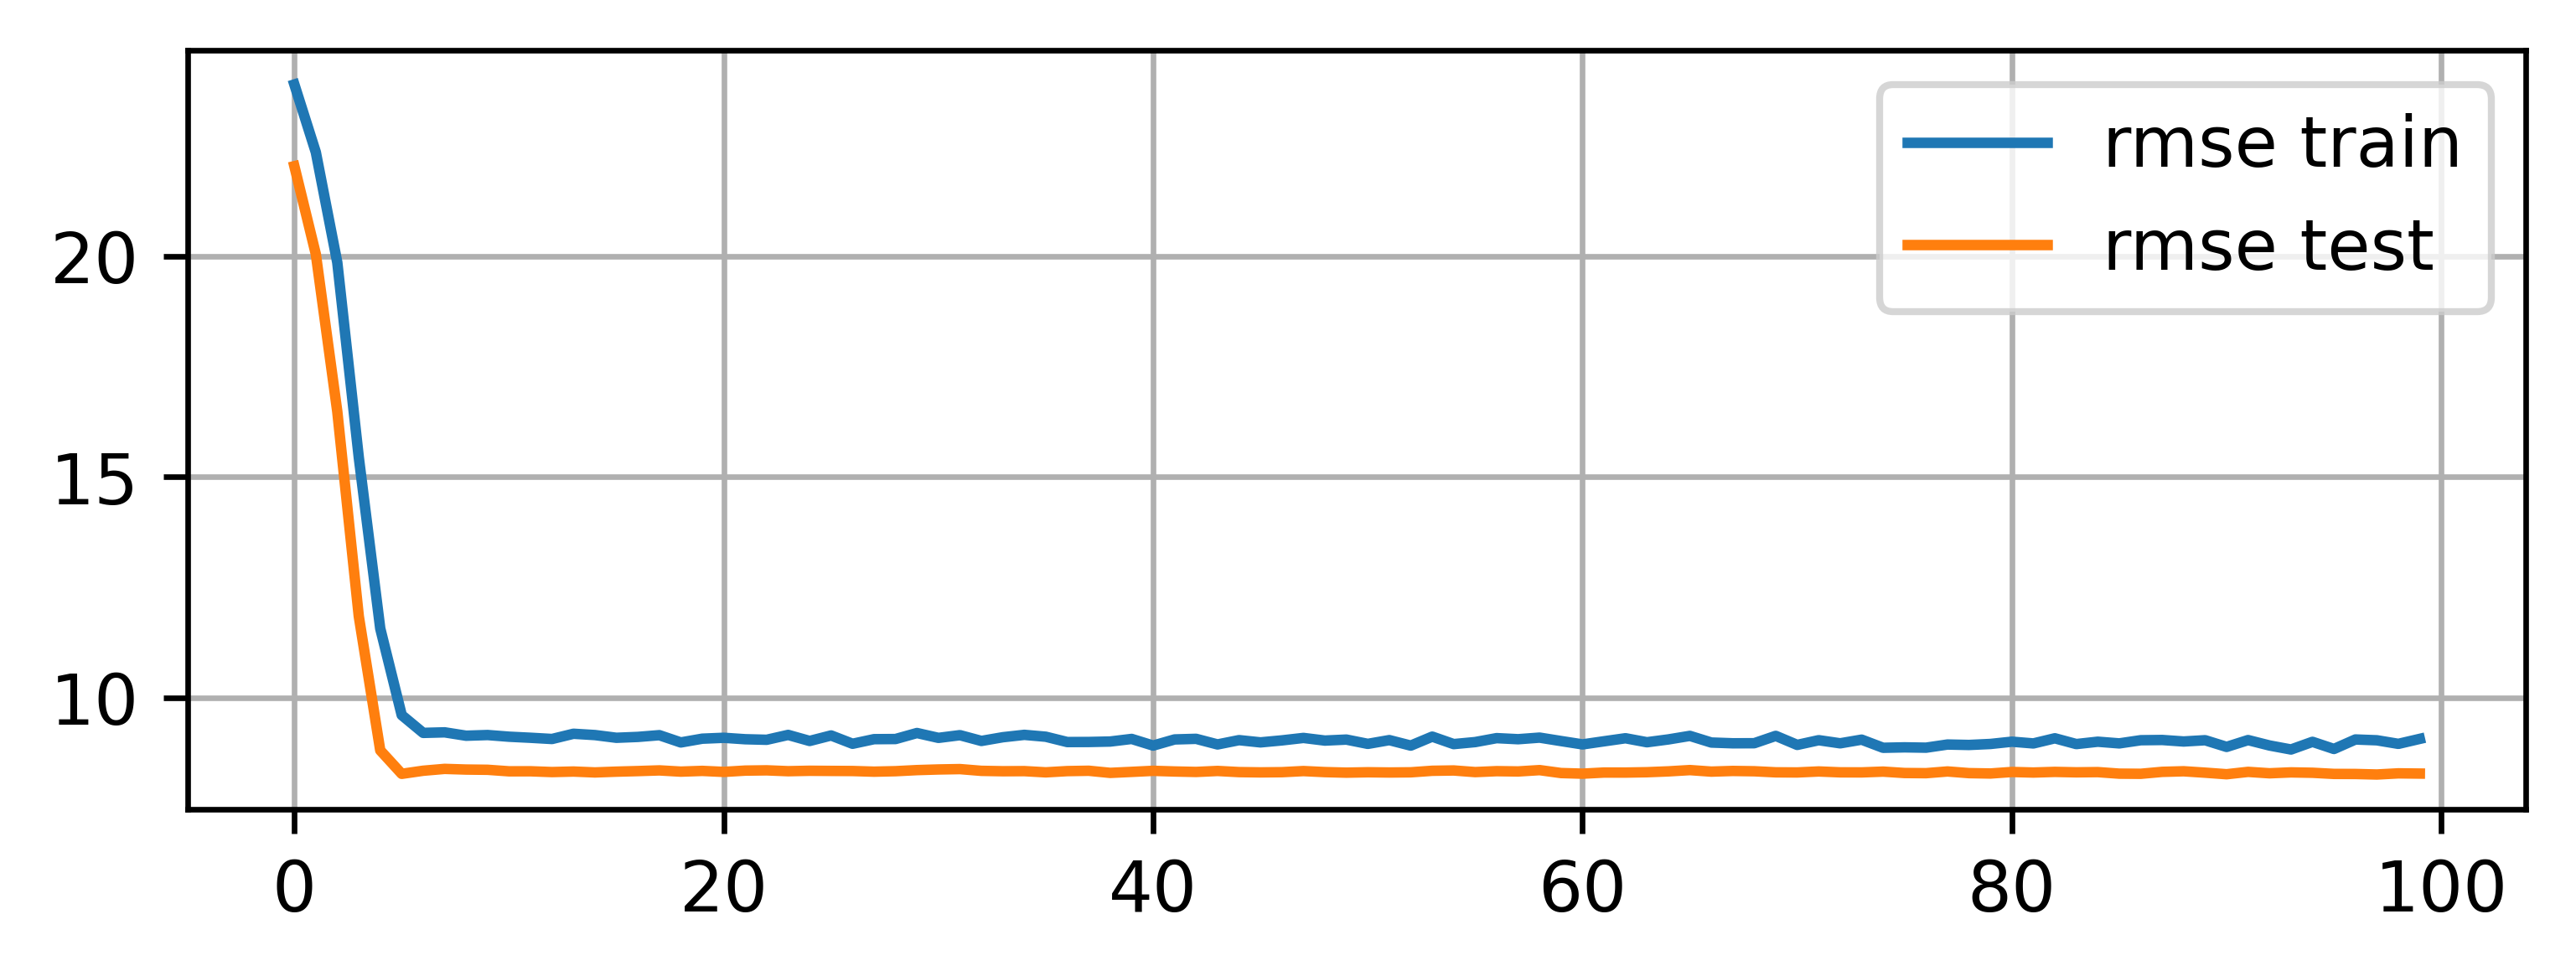

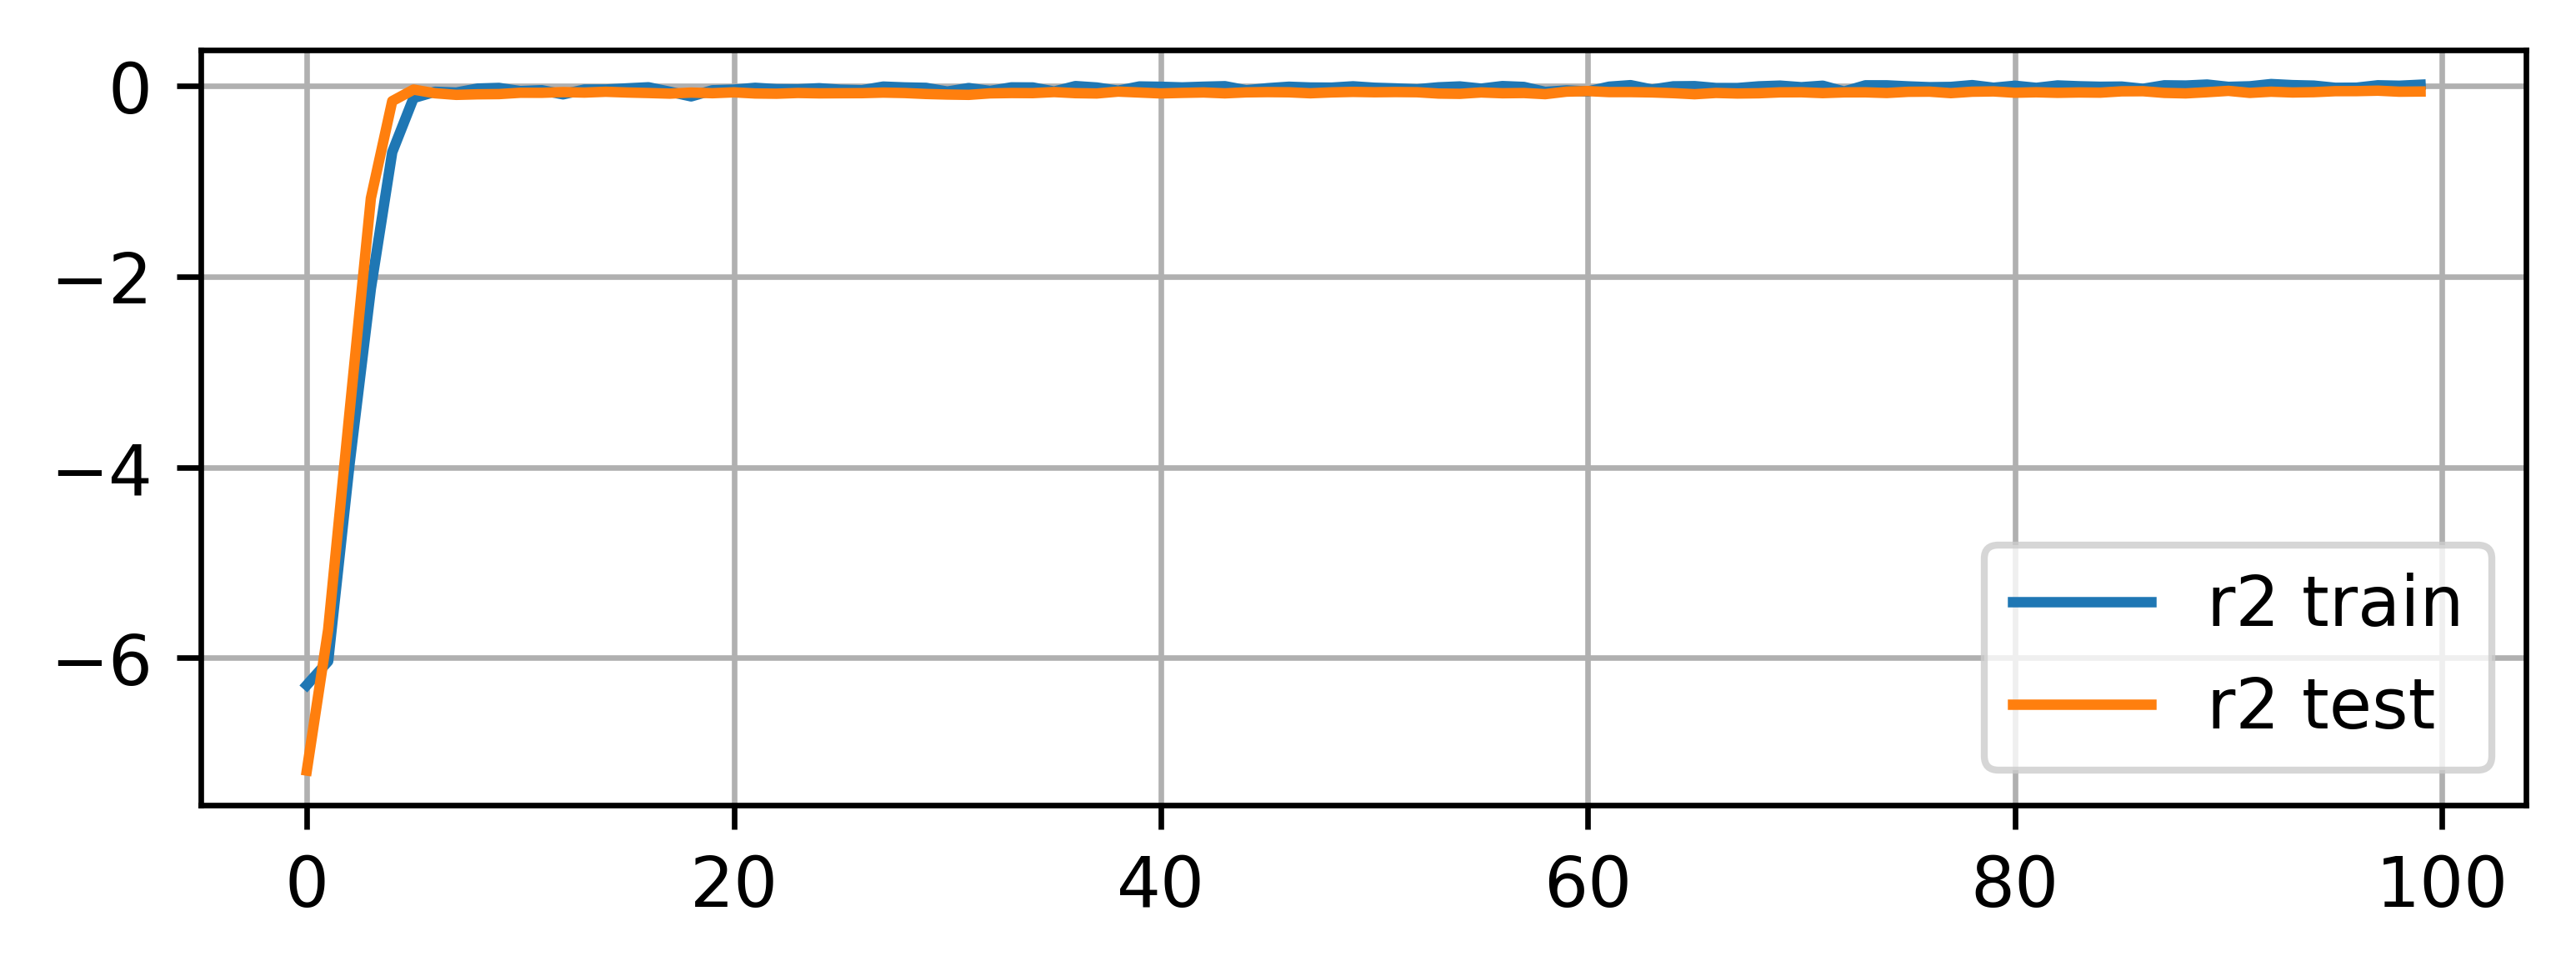

In [7]:
# ---------------------------------------------------------------------------- #
#                                    results                                   #
# ---------------------------------------------------------------------------- #

train_results = model_1.evaluate(X_train, y_train)
test_results = model_1.evaluate(X_test, y_test)

loss_train = history.history["loss"]
loss_test = history.history["val_loss"]

rmse_train = history.history["root_mean_squared_error"]
rmse_test = history.history["val_root_mean_squared_error"]

r2_train = history.history["coeff_determination"]
r2_test = history.history["val_coeff_determination"]

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(loss_train, label="loss train")
plt.plot(loss_test, label="loss test")
plt.legend()
plt.grid()
plt.show()

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(rmse_train, label="rmse train")
plt.plot(rmse_test, label="rmse test")
plt.legend()
plt.grid()
plt.show()

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(r2_train, label="r2 train")
plt.plot(r2_test, label="r2 test")
plt.legend()
plt.grid()
plt.show()

# **$2$. Model_2 ($hidden\_size = 0.5 \times n\_train$)**

In [ ]:
# ---------------------------------------------------------------------------- #
#                            neural network training                           #
# ---------------------------------------------------------------------------- #

opt = keras.optimizers.SGD(learning_rate=0.001)
model_2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[utils.root_mean_squared_error, utils.coeff_determination])
history = model_2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

4/4 [==============================] - 0s 2ms/step - loss: 53.0828 - root_mean_squared_error: 6.6650 - coeff_determination: 0.3200


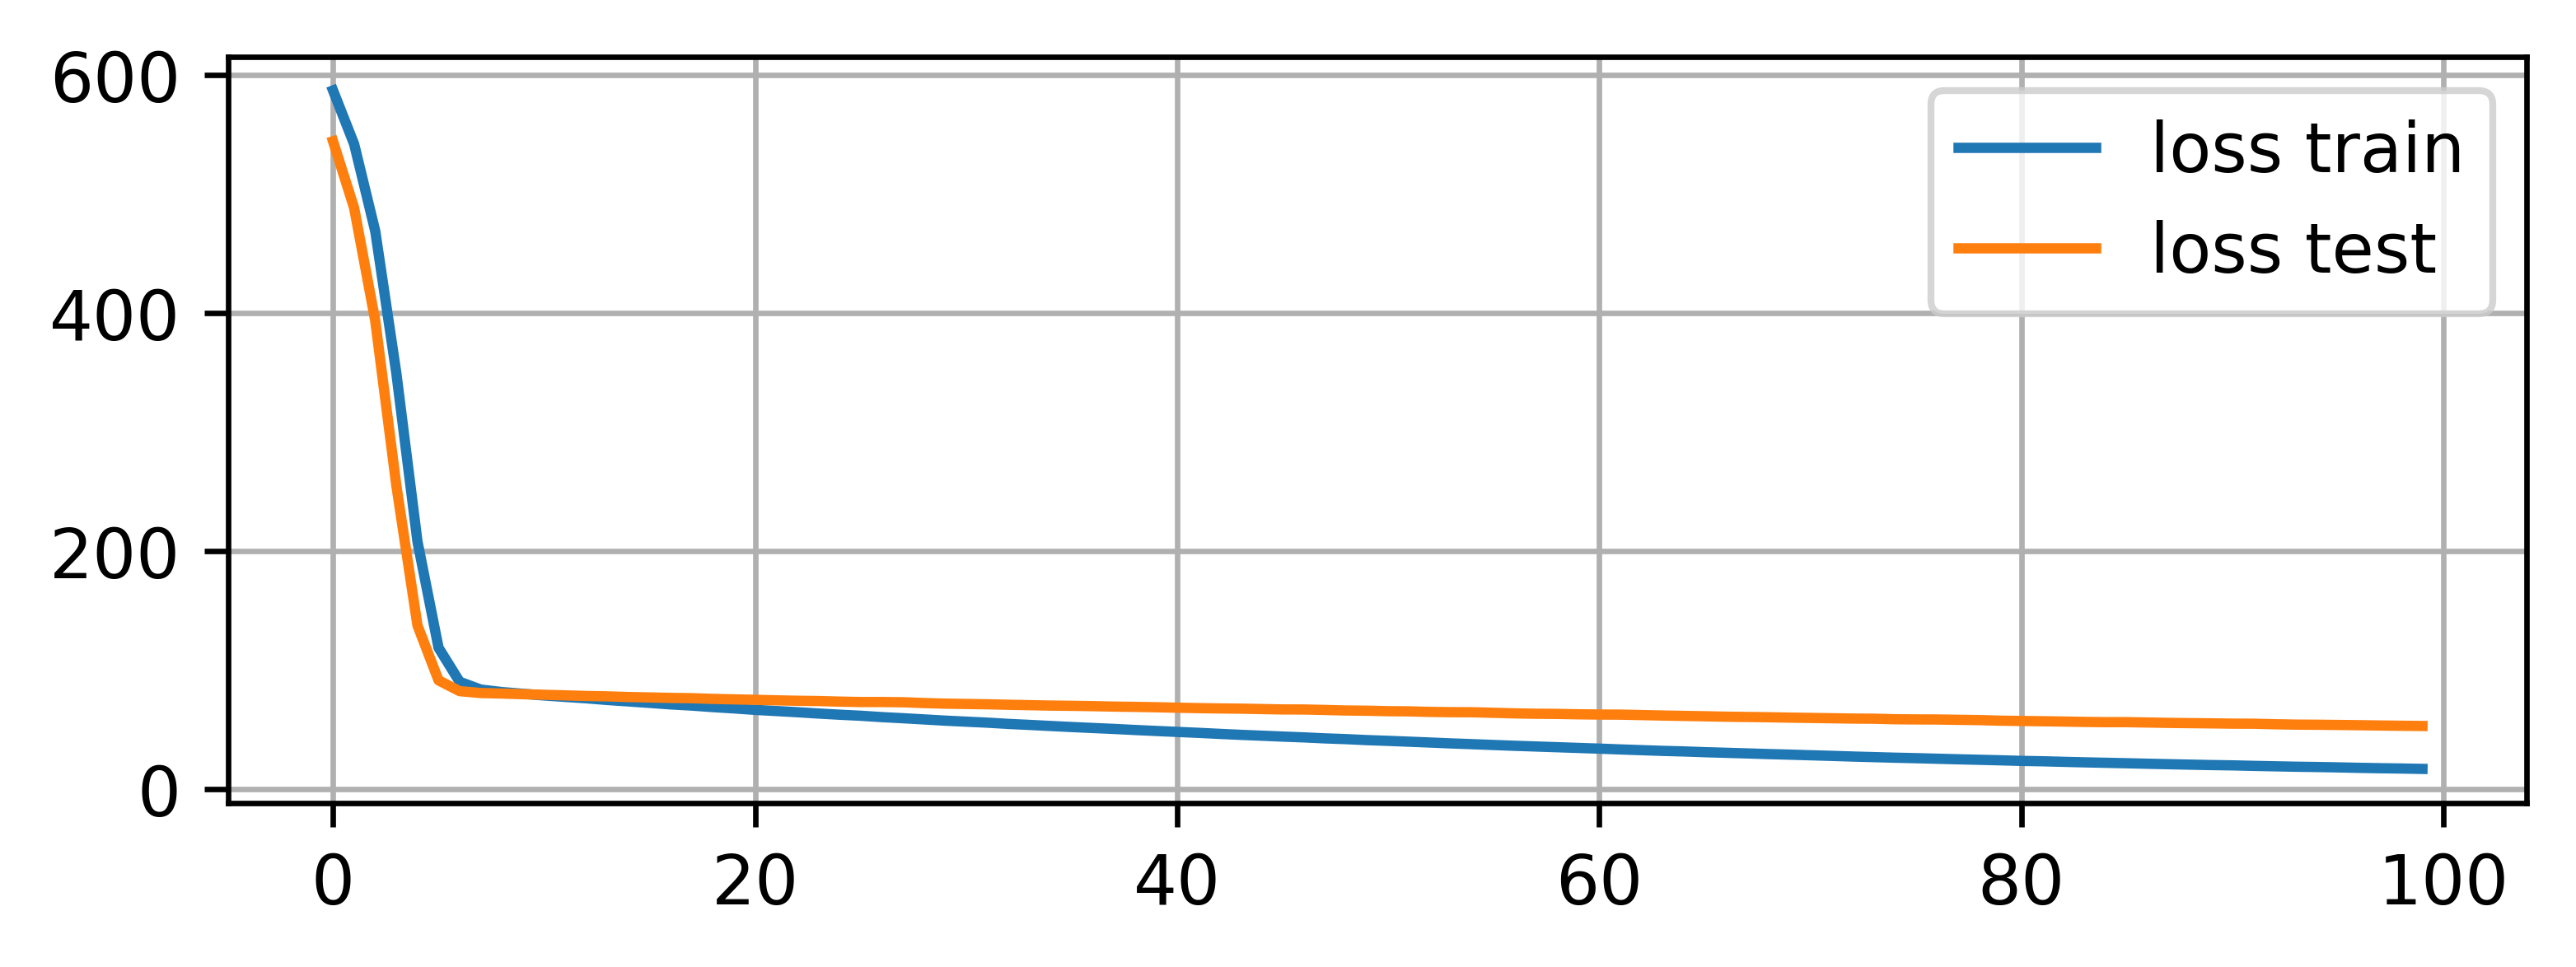

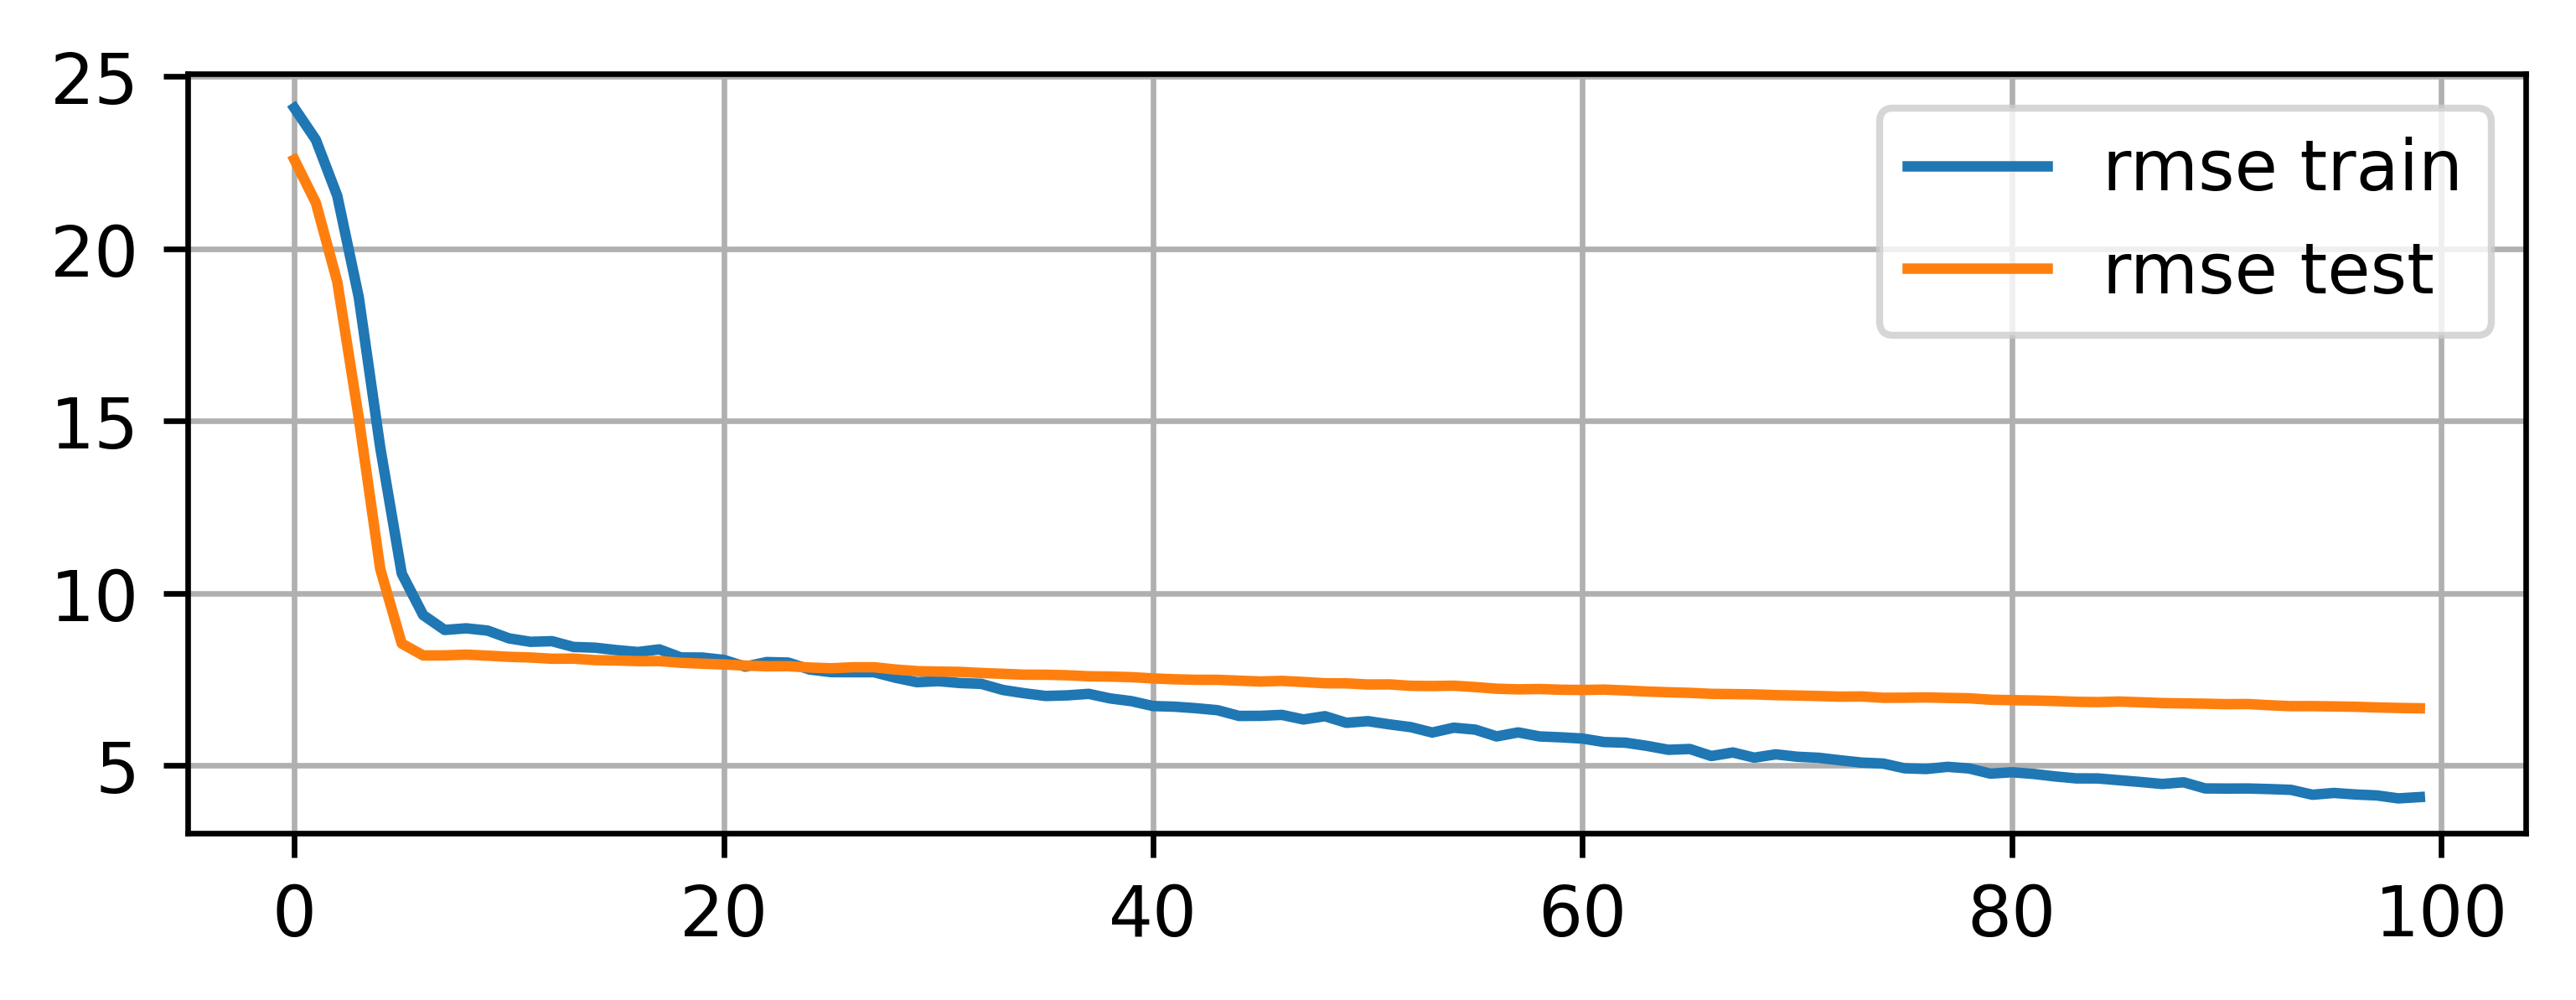

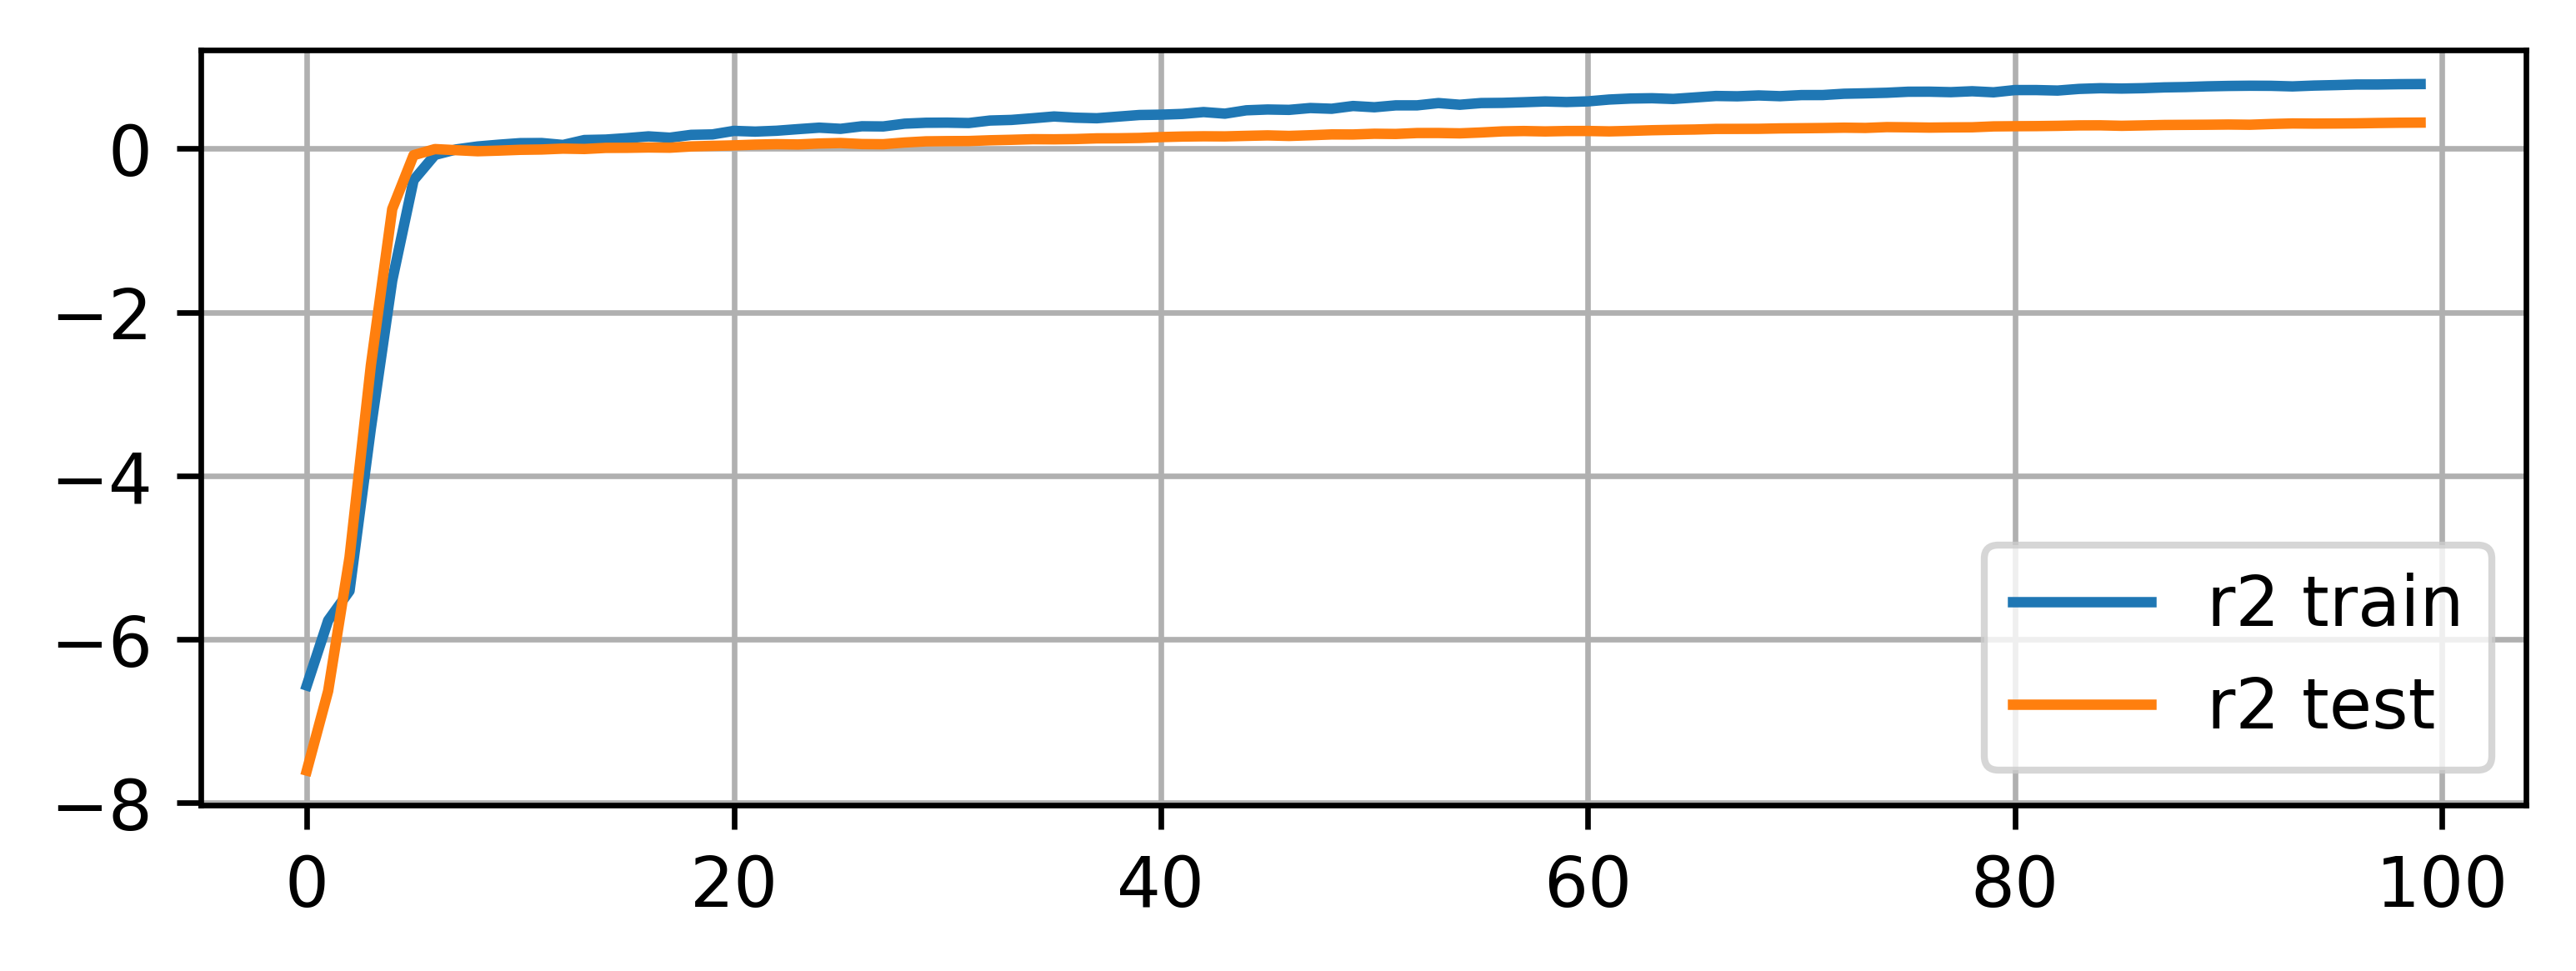

In [10]:
# ---------------------------------------------------------------------------- #
#                                    results                                   #
# ---------------------------------------------------------------------------- #

train_results = model_2.evaluate(X_train, y_train)
test_results = model_2.evaluate(X_test, y_test)

loss_train = history.history["loss"]
loss_test = history.history["val_loss"]

rmse_train = history.history["root_mean_squared_error"]
rmse_test = history.history["val_root_mean_squared_error"]

r2_train = history.history["coeff_determination"]
r2_test = history.history["val_coeff_determination"]

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(loss_train, label="loss train")
plt.plot(loss_test, label="loss test")
plt.legend()
plt.grid()
plt.show()

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(rmse_train, label="rmse train")
plt.plot(rmse_test, label="rmse test")
plt.legend()
plt.grid()
plt.show()

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(r2_train, label="r2 train")
plt.plot(r2_test, label="r2 test")
plt.legend()
plt.grid()
plt.show()

# **$3$. Model_3 ($hidden\_size = 0.9 \times n\_train$)**

In [ ]:
# ---------------------------------------------------------------------------- #
#                            neural network training                           #
# ---------------------------------------------------------------------------- #

opt = keras.optimizers.SGD(learning_rate=0.001)
model_3.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[utils.root_mean_squared_error, utils.coeff_determination])
history = model_3.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

4/4 [==============================] - 0s 2ms/step - loss: 42.1296 - root_mean_squared_error: 5.8417 - coeff_determination: 0.4797


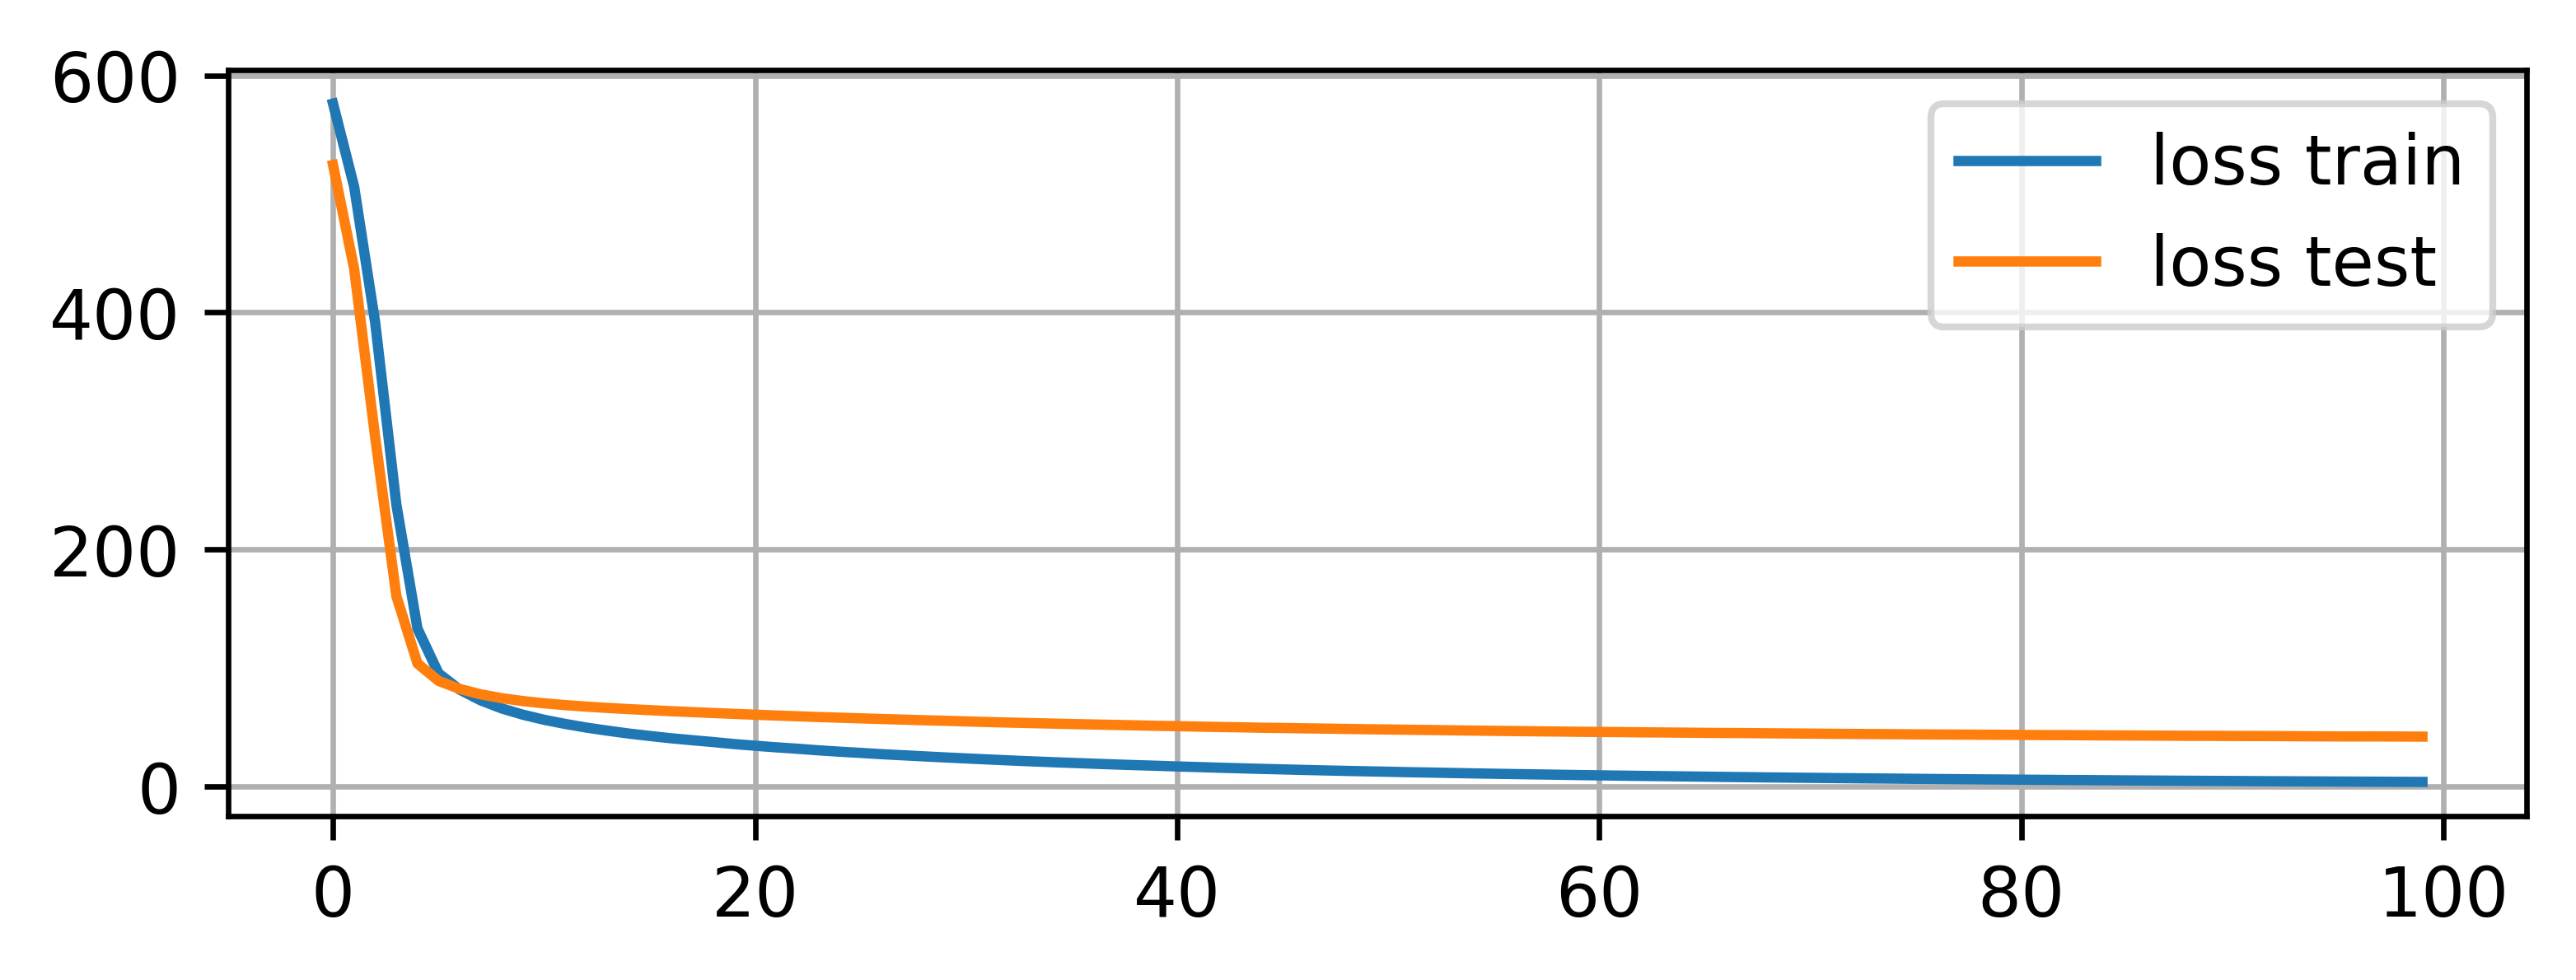

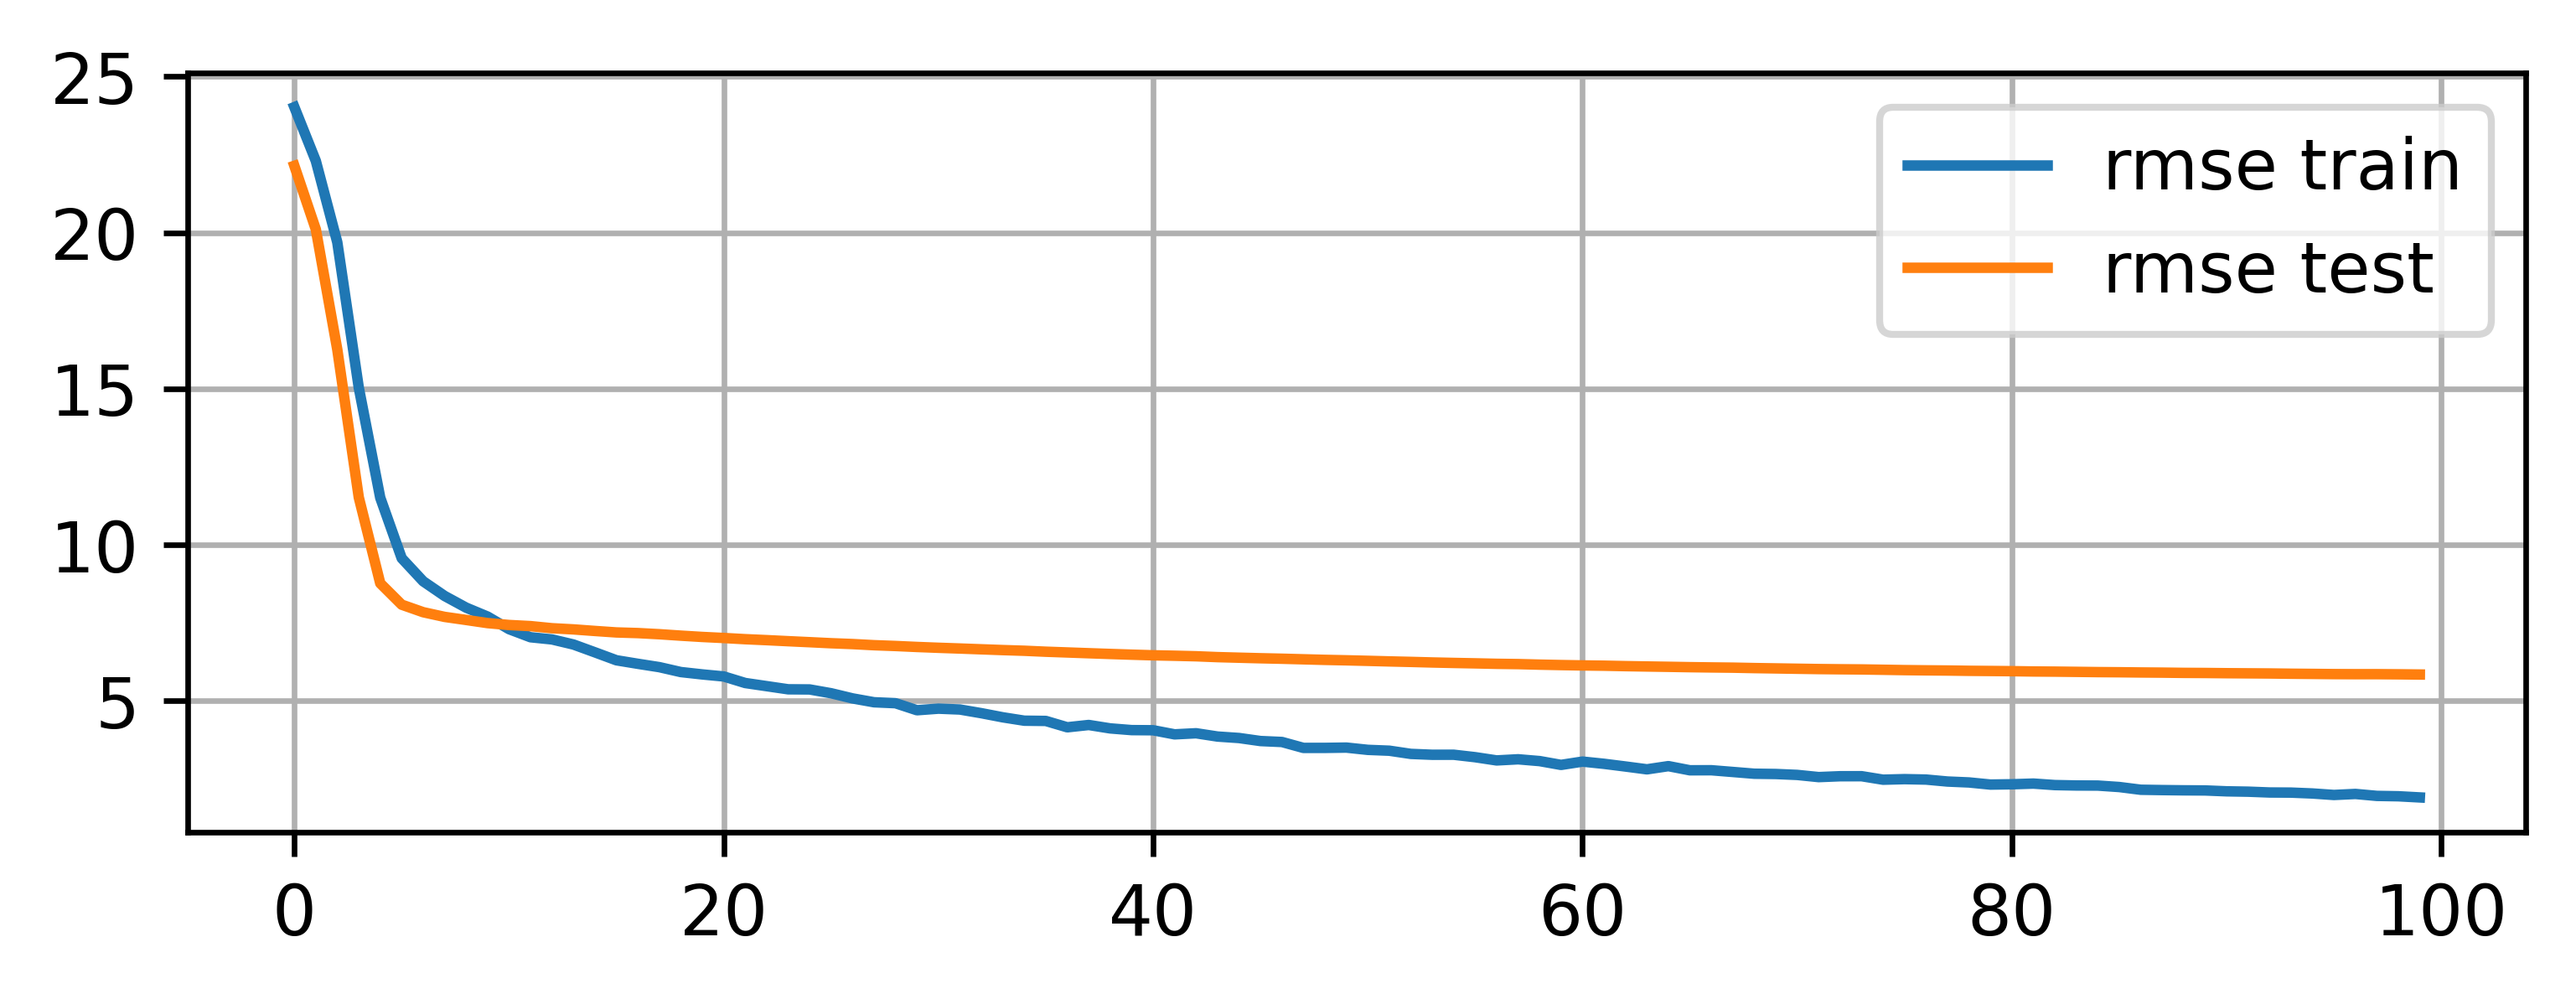

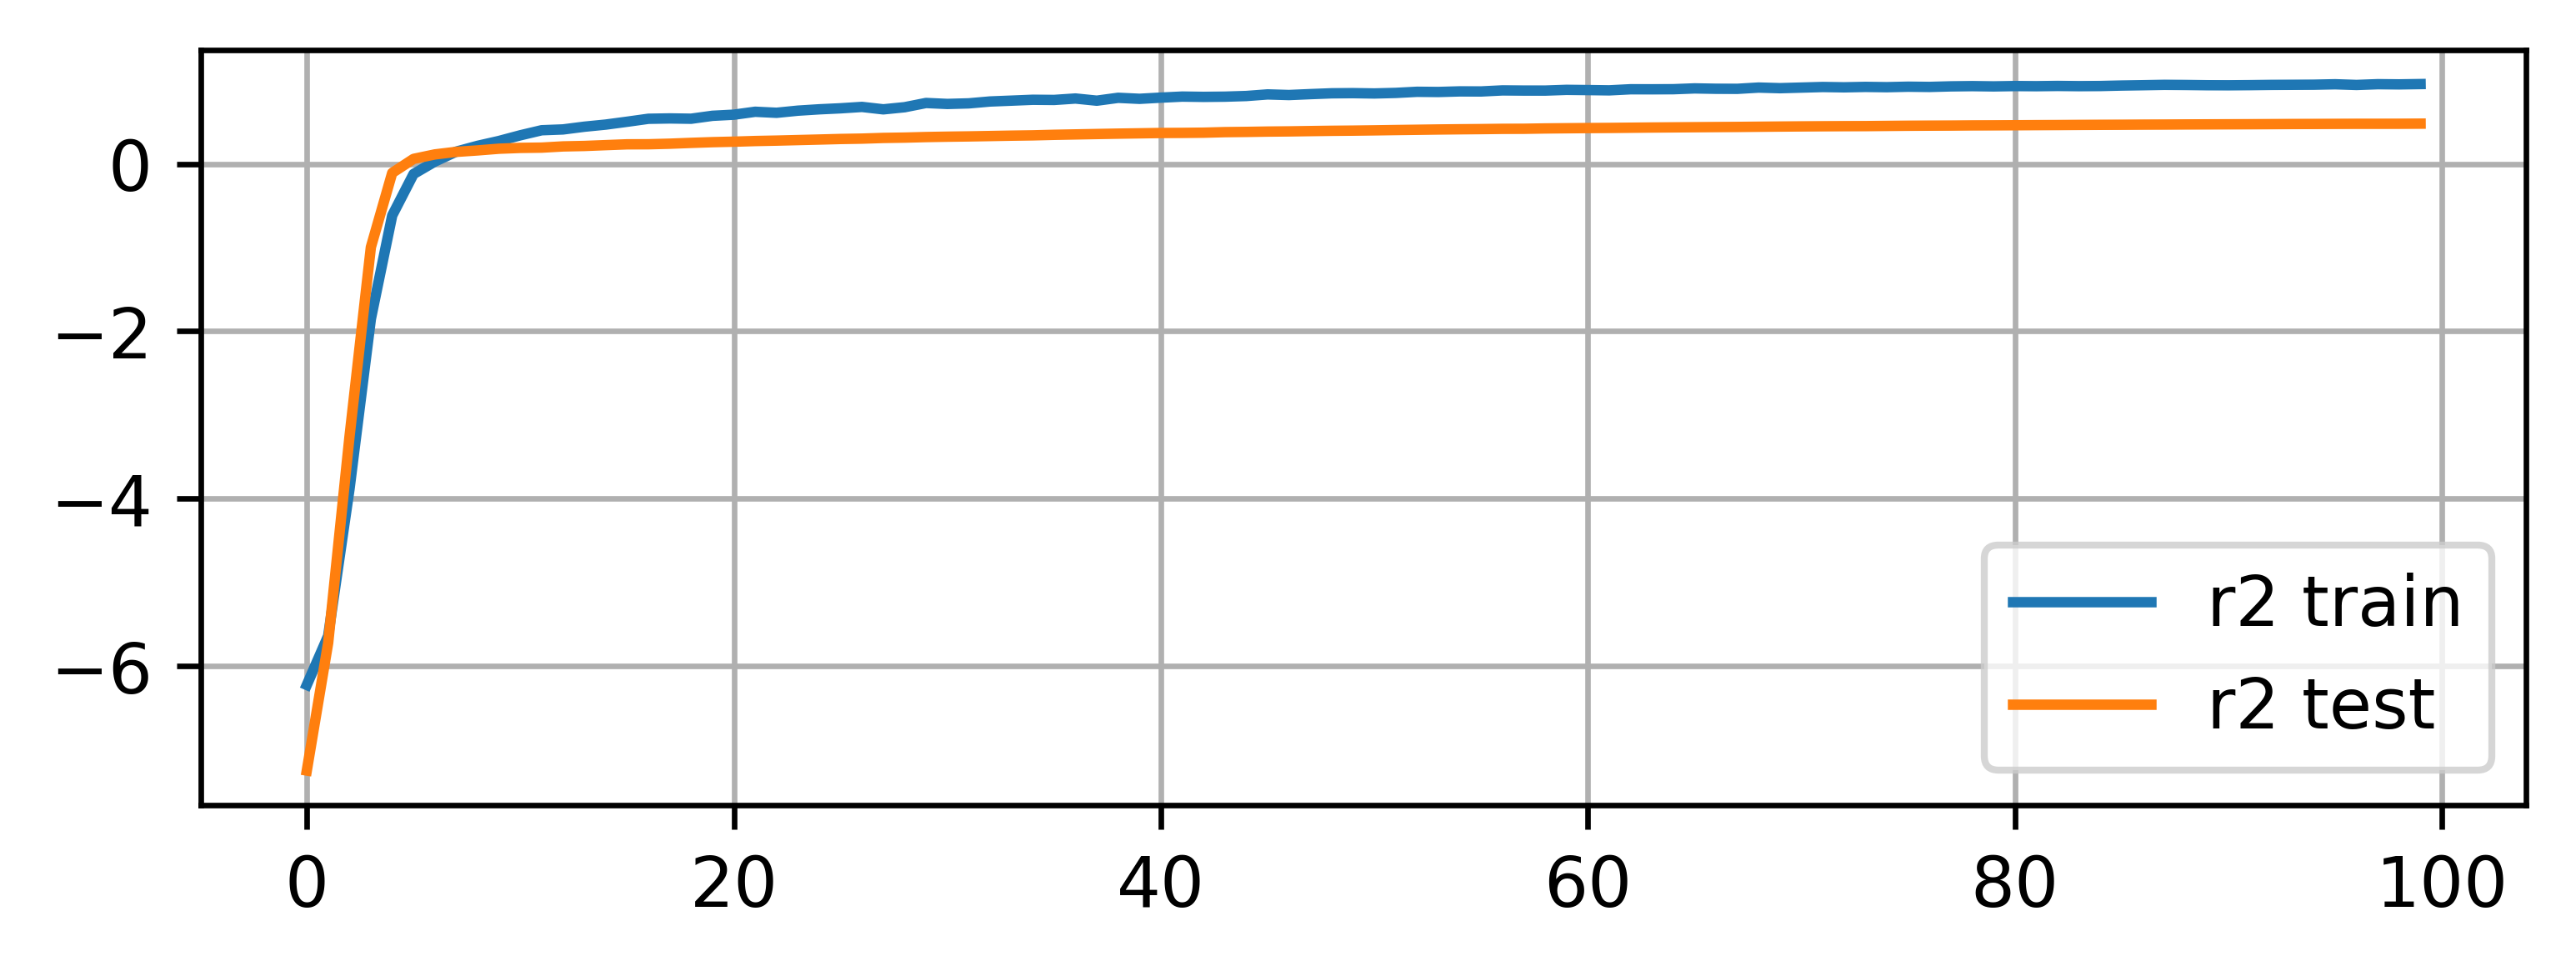

In [13]:
# ---------------------------------------------------------------------------- #
#                                    results                                   #
# ---------------------------------------------------------------------------- #

train_results = model_3.evaluate(X_train, y_train)
test_results = model_3.evaluate(X_test, y_test)

loss_train = history.history["loss"]
loss_test = history.history["val_loss"]

rmse_train = history.history["root_mean_squared_error"]
rmse_test = history.history["val_root_mean_squared_error"]

r2_train = history.history["coeff_determination"]
r2_test = history.history["val_coeff_determination"]

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(loss_train, label="loss train")
plt.plot(loss_test, label="loss test")
plt.legend()
plt.grid()
plt.show()

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(rmse_train, label="rmse train")
plt.plot(rmse_test, label="rmse test")
plt.legend()
plt.grid()
plt.show()

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(r2_train, label="r2 train")
plt.plot(r2_test, label="r2 test")
plt.legend()
plt.grid()
plt.show()

# **Results**
In all three cases the models present similar speed and they fit properly. It is clear that increasing the *RBF* layer size makes the model better in all metrics. Loss function comes closer to 0, *RMSE* decreases faster too and the *coefficient of determination* comes closer to the optimal value 1. 

An interesting observation is that in the learning curves, all training and evaluation curves cross almost simultaneously in each model. For example, in Model 3 we can see that a bit before 10th epoch, the loss curves of training and validation cross and the training curve goes below indicating better performance on training dataset. At the same time, the training curve of *RMSE* goes also below and the *coefficient of determination* above. This means that the learning curves of each metric "agree", validating each other. 

# **Fine Tuning**

On this part we are going to tune the *hyperparameters* of the model using *Keras Tuner*. We consider as *hyperparameters* the size of the *RBF* layer, the size of the output layer and the *dropout probability* of the output layer.

In [35]:
# ---------------------------------------------------------------------------- #
#                                  fine tuning                                 #
# ---------------------------------------------------------------------------- #

import keras_tuner

def build_model(hp):

    model = keras.Sequential()
    model.add(Input(shape=(13,)))
    model.add(rbf_layer.RBF(num_units=hp.Choice("num_units_rbf", [int(0.05 * n_train), int(0.15 * n_train), int(0.3 * n_train), int(0.5 * n_train)]), centers_initializer=utils.InitCentersKMeans(X_train)))
    model.add(keras.layers.Dense(units=hp.Choice("num_units_out", [32, 64, 128, 256]), activation="relu"))
    model.add(keras.layers.Dropout(rate=hp.Choice("dropout_rate", [0.2, 0.35, 0.5]), seed=0))
    model.add(keras.layers.Dense(1, activation="relu"))
    opt = keras.optimizers.SGD(learning_rate=0.001)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[utils.root_mean_squared_error, utils.coeff_determination])
    
    return model

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=50,
    overwrite=False,
    directory="tuning",
    project_name="rbf_tuning",
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
num_units_rbf (Choice)
{'default': 20, 'conditions': [], 'values': [20, 60, 121, 202], 'ordered': True}
num_units_out (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.35, 0.5], 'ordered': True}


In [36]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Trial 50 Complete [00h 00m 15s]
val_loss: 52.5495491027832

Best val_loss So Far: 52.49432373046875
Total elapsed time: 00h 12m 41s
INFO:tensorflow:Oracle triggered exit


In [37]:
print("Optimal model:")
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_model.summary()

print("Optimal parameters:")
num_units_rbf_opt = best_hyperparameters.get("num_units_rbf")
num_units_out_opt = best_hyperparameters.get("num_units_out")
dropout_rate_opt  = best_hyperparameters.get("dropout_rate")

print("num_units_rbf_opt =", num_units_rbf_opt)
print("num_units_out_opt =", num_units_out_opt)
print("dropout_rate_opt =", dropout_rate_opt)

Optimal model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf (RBF)                   (None, 202)               2626      
                                                                 
 dense (Dense)               (None, 256)               51968     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 54,851
Trainable params: 52,225
Non-trainable params: 2,626
_________________________________________________________________
Optimal parameters:
num_units_rbf_opt = 202
num_units_out_opt = 256
dropout_rate_opt = 0.2


Having found the optimal *hyperparameters*, now we construct and train the optimal model.

In [5]:
num_units_rbf_opt = 202
num_units_out_opt = 256
dropout_rate_opt = 0.2

best_model = keras.Sequential()
best_model.add(Input(shape=(13,)))
best_model.add(rbf_layer.RBF(num_units=num_units_rbf_opt, centers_initializer=utils.InitCentersKMeans(X_train)))
best_model.add(keras.layers.Dense(units=num_units_out_opt, activation="relu"))
best_model.add(keras.layers.Dropout(rate=dropout_rate_opt , seed=0))
best_model.add(keras.layers.Dense(1, activation="relu"))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf (RBF)                   (None, 202)               2626      
                                                                 
 dense (Dense)               (None, 256)               51968     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 54,851
Trainable params: 52,225
Non-trainable params: 2,626
_________________________________________________________________


In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.001)
best_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[utils.root_mean_squared_error, utils.coeff_determination])
history = best_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

In [7]:
# ---------------------------------------------------------------------------- #
#                                  evaluation                                  #
# ---------------------------------------------------------------------------- #

train_results = best_model.evaluate(X_train, y_train)
test_results = best_model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 53.4155 - root_mean_squared_error: 6.6659 - coeff_determination: 0.3224


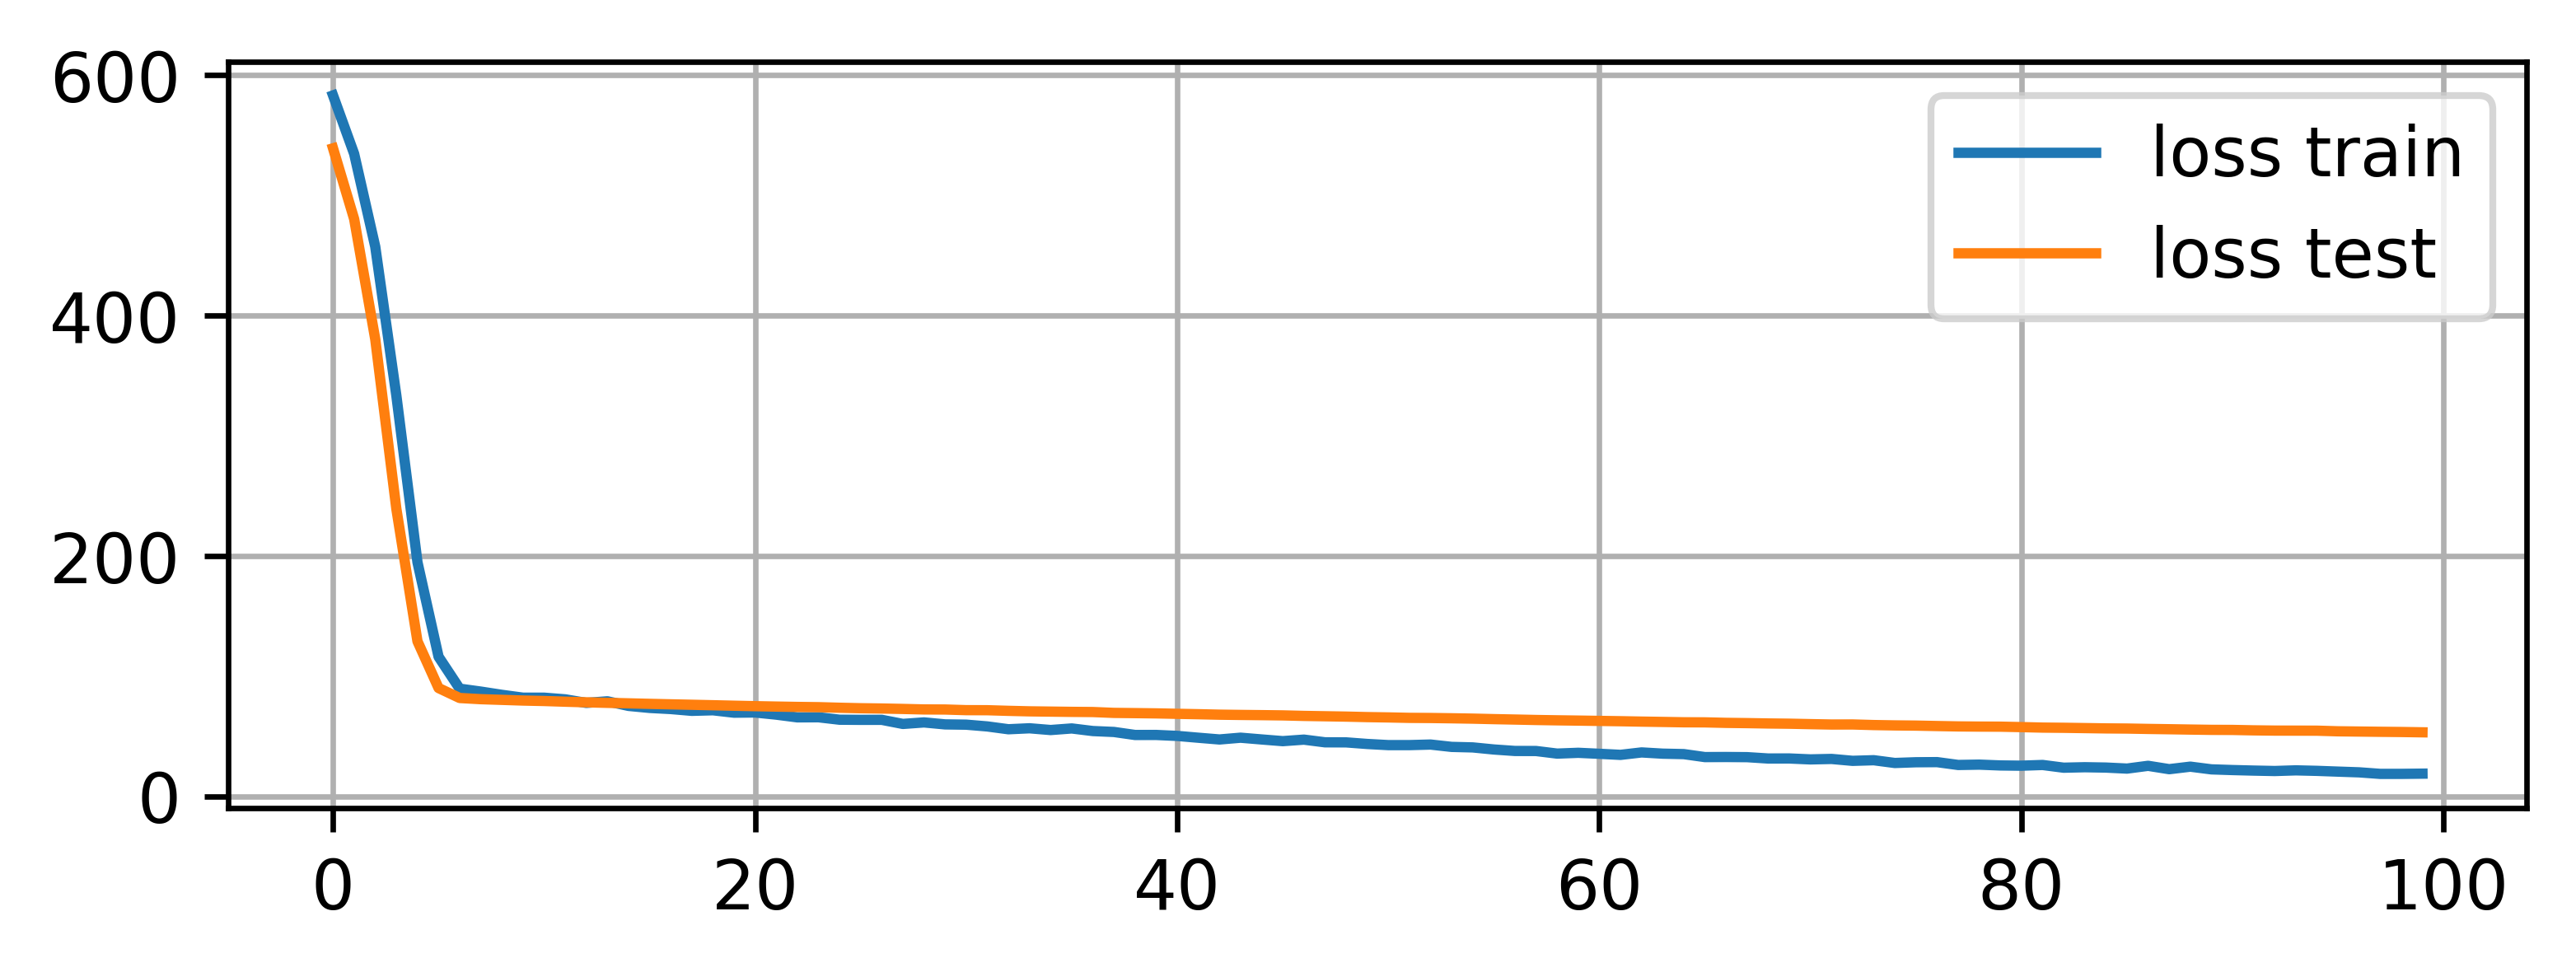

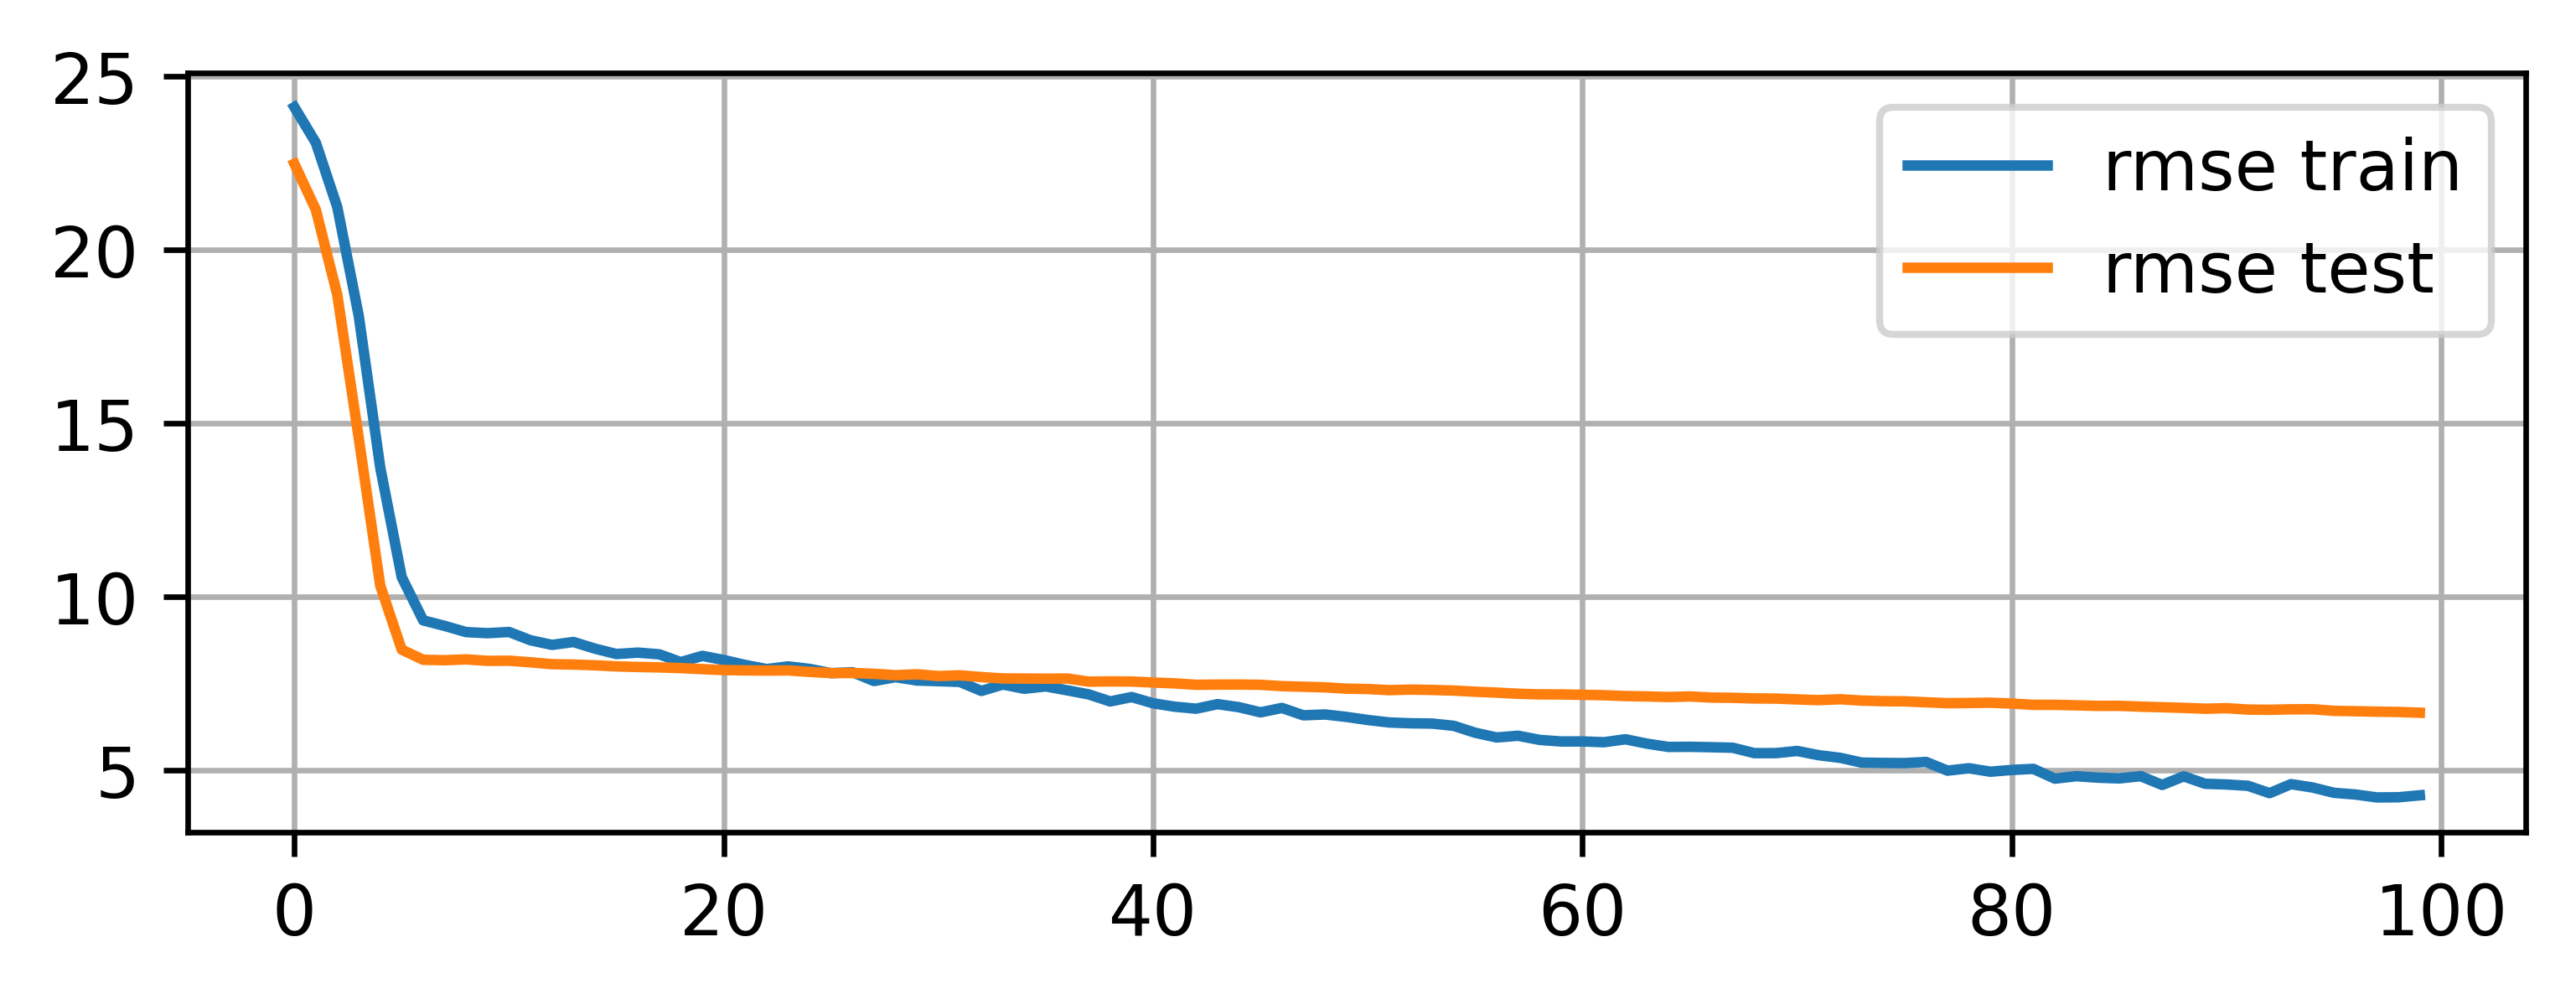

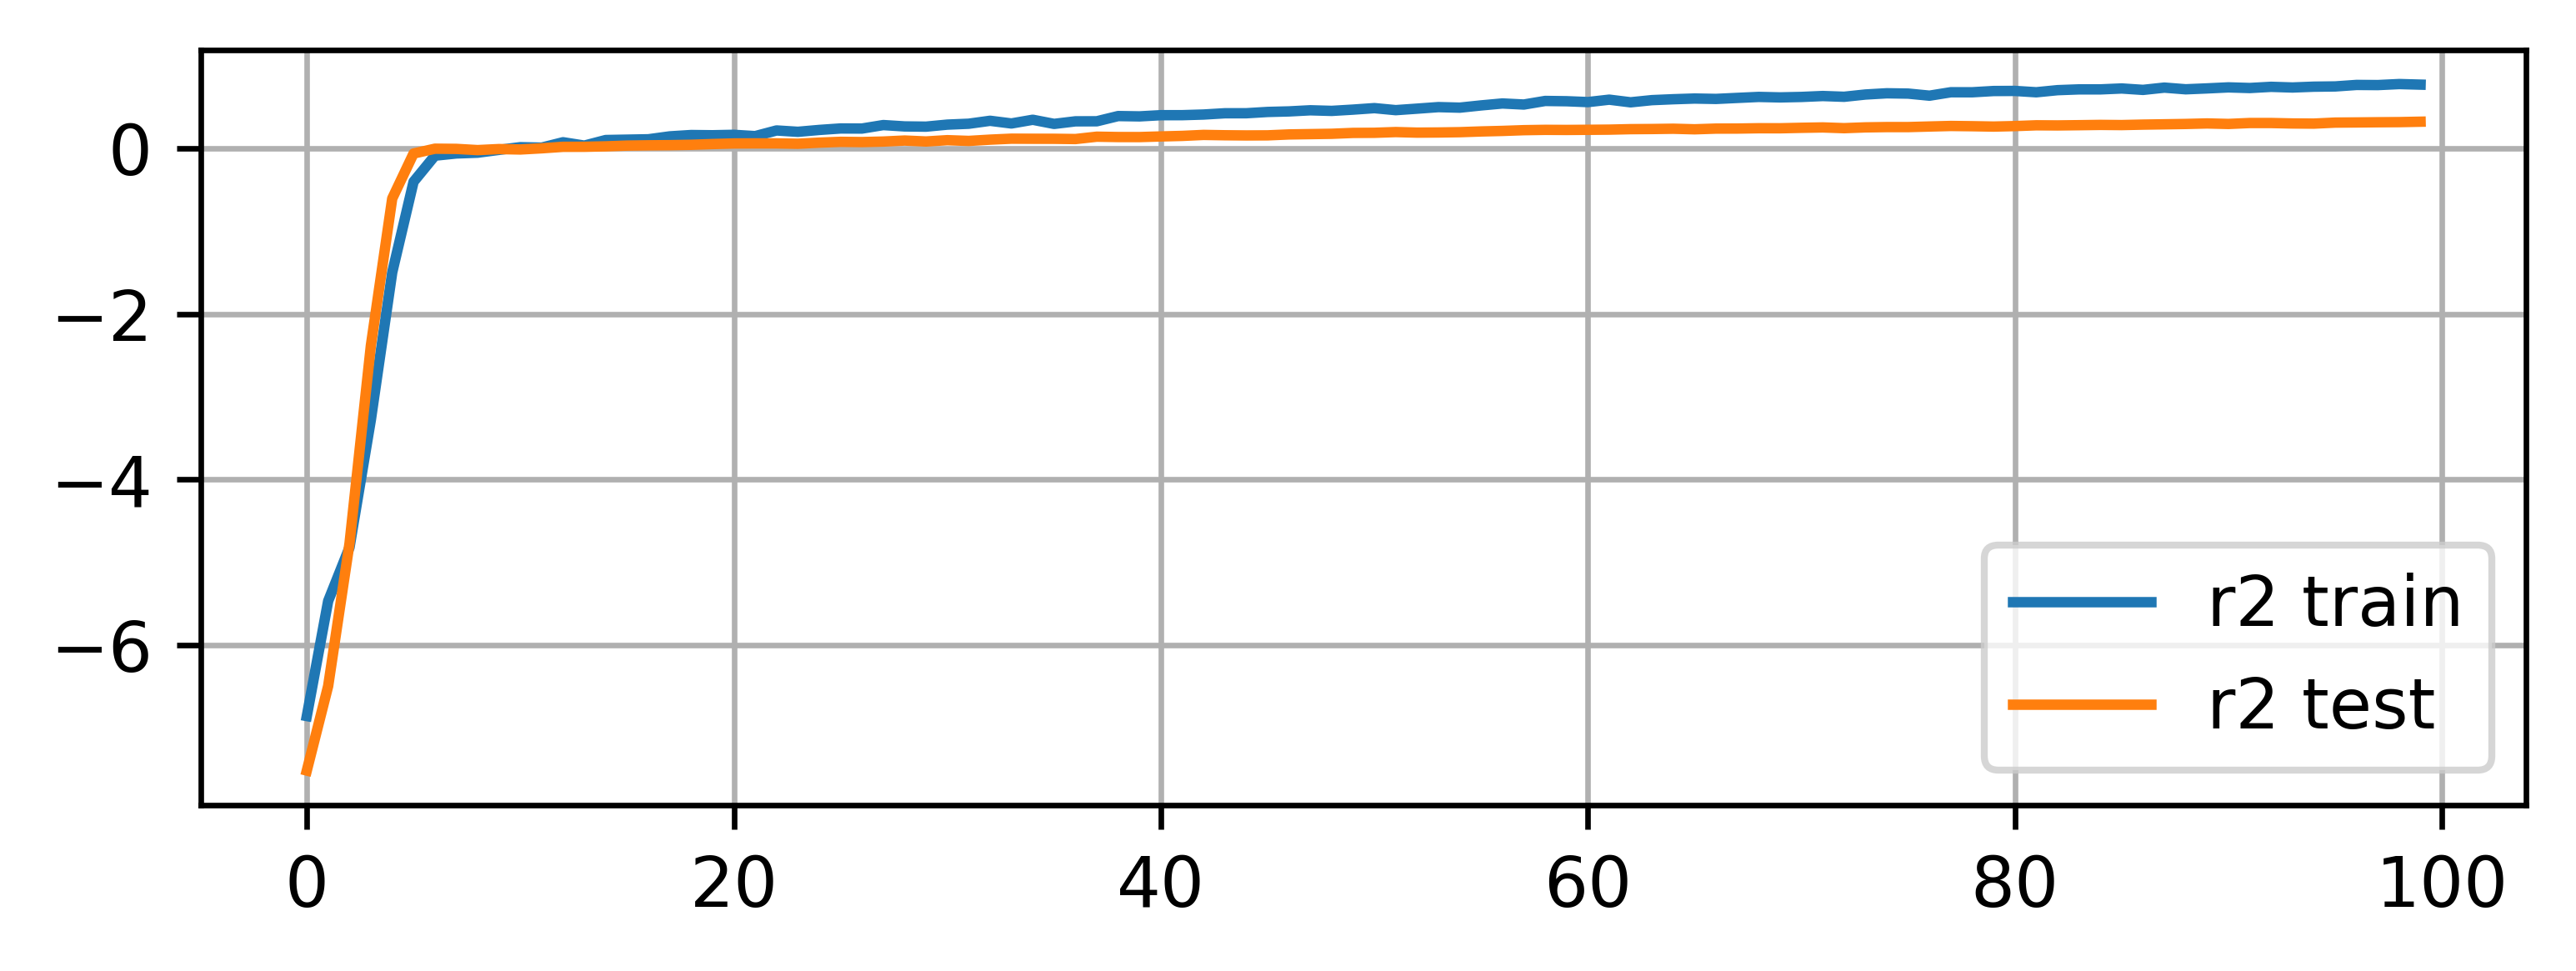

In [8]:
loss_train = history.history["loss"]
loss_test = history.history["val_loss"]

rmse_train = history.history["root_mean_squared_error"]
rmse_test = history.history["val_root_mean_squared_error"]

r2_train = history.history["coeff_determination"]
r2_test = history.history["val_coeff_determination"]

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(loss_train, label="loss train")
plt.plot(loss_test, label="loss test")
plt.legend()
plt.grid()
plt.show()

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(rmse_train, label="rmse train")
plt.plot(rmse_test, label="rmse test")
plt.legend()
plt.grid()
plt.show()

plt.ion()
plt.figure(figsize=(6, 2), dpi=600)
plt.plot(r2_train, label="r2 train")
plt.plot(r2_test, label="r2 test")
plt.legend()
plt.grid()
plt.show()